In [1]:
%%capture
run "harmonic0.ipynb"

In [16]:
import numpy as np

In [373]:
def string(x, delta = 1, e = 1):
    return e*((x / delta)**4 - 2*(x / delta)**2 + 1)

In [442]:
def string(x, D = 30, b = 1, x0 = 1):
    return D*(np.exp(-2 * b * (x-x0)) - 2 * np.exp(-b * (x-x0)) + 1)

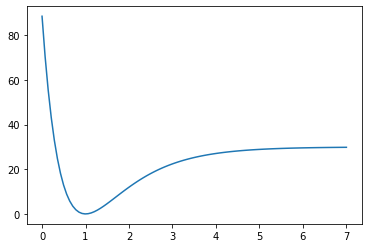

In [443]:
k = 7
plt.plot(np.linspace(0, k, 100), string(np.linspace(0, k, 100)))

In [4]:
def turnPoint(x, energy, potential):
    """
    Function that calcs the turning point
    that is needed for classDensity
    """
    turnFunc = energy - potential(x)

    turnIndex = 0
    for i in range(1, len(turnFunc)-1):
        if potential(x[i]) > energy: 
            turnIndex = i
            break

    return turnIndex 

In [5]:
def numerovSchemeReverse(x, y0, y1, func, energy, deltaX, potential):
    """
    Numerov numeric method.
    Input:
    x  - mesh points x0, x1, ..., xN
    y0 - initial condition, value of y[0]
    y1 - initial condition, value of y[1]
    f  - function where potential is included 
    Output:
    y  - array of y(x0), y(x1), ..., y(xN) according to Numerov method 
    """

    # Initializing the ouput array with zeros
    y = np.zeros(len(x))
    # Initial conditions
    y[len(x)-1] = y0
    y[len(x)-2] = y1
    # Creating array of f(x0), f(x1), ..., f(xN)
    f = func(x, energy, deltaX, potential)
    # Main cycle of numeric scheme
    for i in range(len(x)-2)[::-1]:
        # Preventing zero division
        if (f[i] == 0.0): f[i] = 1E-20 
        y[i] = ( (12.0 - 10.0 * f[i+1]) * y[i+1] - f[i+2] * y[i+2] ) / f[i] 
    
    return y

In [6]:
def normalizeWF(y, deltaX):
    """
    Helper function that perfoms wave function normalization
    i.e. int |y(x)|**2 dx = 1
    """
    norm = 0.0 
    for i in range(1, len(y)):
        norm += 2.0 * y[i]**2 * deltaX 
    norm += 1.0 * y[0]**2 * deltaX

    y_norm = y / np.sqrt(norm)

    return y_norm

In [7]:
def calcDiscontinuity(y, x, deltaX, energy, turnIndex):
    """
    Helper function that caculates the distcontinuity in
    y'(x) at turning point. Again we are using Numerov algrothim
    for that estimate
    """
    return ( y[turnIndex - 1] + y[turnIndex + 1] - \
        (14 - 12 * func(x[turnIndex], energy, deltaX, potential=string)) * y[turnIndex] ) / deltaX

In [8]:
def bisectionIm(xmax, nmax, numNodes, trialEnergy):
    """
    """
    x = np.linspace(0, xmax, nmax+1)

    deltaX = float(xmax) /float(nmax)

    numIter = 0
    if trialEnergy == 0:
        maxEnergy = 100.0
        minEnergy = 0.0
        trialEnergy, minEnergy, maxEnergy, numIter = bisectionImFirst(x, minEnergy, maxEnergy, numIter=numIter, numNodes=numNodes)
    else:
        minEnergy = trialEnergy
        maxEnergy = trialEnergy

    res = bisectionImSecond(x=x, energy=trialEnergy, minEnergy=minEnergy, maxEnergy=maxEnergy, numIter=numIter, numNodes=numNodes, verbose=True)

    return res

In [416]:
def bisectionImFirst(x, minEnergy, maxEnergy, numNodes, numIter, verbose=True):
    """
    Fist part of bisectionIm where
    enery is lowered until the number of nodes 
    would coincide with desired number
    """
    deltaX = x[1] - x[0]
    energy = (maxEnergy + minEnergy) / 2.0
    
    # Print header
    print("Fist Stage")
    print(80*"-")
    print("\tInter\t\tEnergy\t\tNumNodes\tDesired NumNodes")
    while True:
        # Increasing number of interations
        numIter += 1

        # Beware the integer division: 1/2 = 0 !
        # if nodes is even, there are 2*halfNodes nodes
        # if nodes is odd,  there are 2*halfNodes+1 nodes (one is in x=0)
        # hnodes is thus the number of nodes in the x>0 semi-axis (x=0 excepted)
        halfNodes = numNodes 
        print(halfNodes)

        # Different initial condigion for diffrent even and odd number of nodes
        #if numNodes % 2 == 0:
#             y0 = 1.0 # some arbitrary finite number
#             y1 = ( (12.0 - 10.0 * func(x[0], energy, deltaX, potential=string)) * y0 / \
#                 (2.0 * func(x[1], energy, deltaX, potential=string)) )
#         else:
#             y0 = 0.0
#             y1 = deltaX # small number finite number
        y0 = deltaX
        y1 = deltaX

        # Caclulating y 
        y = numerovScheme(x, y0, y1, func, energy, deltaX, string)

        # Calculating new value of energy that depends on
        # current number of nodes
        numNodesFromY = howManyNodes(y)

        if verbose:
            print('%10d\t%10.10f\t%10d\t%10d' % (numIter, energy, numNodesFromY, halfNodes))

        if numNodesFromY > halfNodes:
            maxEnergy = energy
        elif numNodesFromY < halfNodes:
            minEnergy = energy
        else:
            break

        energy = (maxEnergy + minEnergy) / 2.0

    print(80*'-')
    
    return energy, minEnergy, maxEnergy, numIter

In [439]:
def bisectionImSecond(x, energy, minEnergy, maxEnergy, numIter, numNodes, tolerance = 1E-10, verbose=True):
    """
    Second stage of bisection where use the continious
    of derivitive of the wave function at turning point
    """
    deltaX = x[1]-x[0]

    assert energy == (minEnergy + maxEnergy) / 2.0, 'Something wrong with the energy'

    # Print header
    print("Second Stage")
    print(80*"-")
    print("\tInter\t\tEnergy\t\tNumNodes\tDiscontinuity")

    while True:
        numIter += 1
        # Calulating the turning point	
        #turnIndex = turnPoint(x=x, energy=energy, potential=string)
        # Apply NumerovScheme for region |x| < x_turnPoint 
        # Different initial condigion for diffrent even and odd number of nodes
#         if numNodes % 2 == 0:
#             y0 = 1.0 # some arbitrary finite number
#             y1 = ( (12.0 - 10.0 * func(x[0], energy, deltaX, potential=string)) * y0 / \
#                     (2.0 * func(x[1], energy, deltaX, potential=string)) )
#         else:
#             y0 = 0.0
#             y1 = deltaX # small number finite number
        y0 = deltaX
        y1 = deltaX
        
        turnIndex = nmax // xmax

        y = np.zeros(len(x))
        # Calc y at |x| < x_turningPoint
        y[:turnIndex+1] = numerovScheme(x[:turnIndex+1], y0, y1, func, energy, deltaX, string)

        y_right = y[turnIndex]

        # Calc y at x_turningPoint < |x| < x_max
        y0 = deltaX
        y1 = deltaX
        y[turnIndex:] = numerovSchemeReverse(x[turnIndex:], y0, y1, func, energy, deltaX, string)
        y_left = y[turnIndex]

        # Scaling wave function
        scale = y_right / y_left
        y[turnIndex:] *= scale

        # Normalizing wave function
        y = normalizeWF(y, deltaX)

        numNodesFromY = howManyNodes(y)
        halfNumNodes = numNodes 
        discontinuity = calcDiscontinuity(y, x, deltaX, energy, turnIndex)*np.sign(y[turnIndex])

        if numNodesFromY != halfNumNodes: 
            if verbose:
                print('%10d\t%10.10f\t%10d' % (numIter, energy, numNodesFromY))
            if numNodesFromY > halfNumNodes:
                maxEnergy = energy
            elif numNodesFromY < halfNumNodes:
                 minEnergy = energy
                
            #energy = (maxEnergy + minEnergy) / 2.0
                
            energy, minEnergy, maxEnergy, numIter = bisectionImFirst(x, minEnergy, maxEnergy, numIter=numIter, numNodes=numNodes)
            # Print header
            print("Second Stage")
            print(80*"-")
            print("\tInter\t\tEnergy\t\tNumNodes\tDiscontinuity")
        else:
            if verbose:
                print('%10d\t%10.10f\t%10d\t\t%10.7f' % (numIter, energy, numNodesFromY, discontinuity))
            if discontinuity >= 0:
                maxEnergy = energy
            else:
                minEnergy = energy

            energy = (maxEnergy + minEnergy) / 2.0
            
            if abs(maxEnergy - minEnergy) < tolerance: break

        if maxEnergy == energy and minEnergy == energy: break 
        
    
    return energy, x, y

## Задание 1.

In [437]:
nodes = [0, 1, 5, 10, 20, 45]
x_1 = []
y_1 = []
energy_1 = []
for i in nodes:
    xmax = 10
    nmax = 100
    numNodes = i
    trialEnergy = 0.0
    energy, x, y = bisectionIm(xmax=xmax, nmax=nmax, numNodes=numNodes, trialEnergy=trialEnergy)
    x_1.append(x)
    y_1.append(y)
    energy_1.append(energy)

Fist Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Desired NumNodes
0
         1	50.0000000000	        25	         0
0
         2	25.0000000000	        13	         0
0
         3	12.5000000000	         7	         0
0
         4	6.2500000000	         3	         0
0
         5	3.1250000000	         2	         0
0
         6	1.5625000000	         1	         0
0
         7	0.7812500000	         1	         0
0
         8	0.3906250000	         0	         0
--------------------------------------------------------------------------------
Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity
         9	0.3906250000	         0		-0.2181716
        10	0.5859375000	         0		 0.2091396
        11	0.4882812500	         0		-0.0257955
        12	0.5371093750	         0		 0.0903734
        13	0.5126953125	         0		 0.0308638
        14	0.5004882812	      

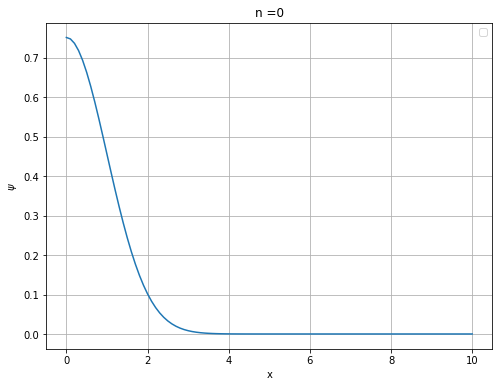

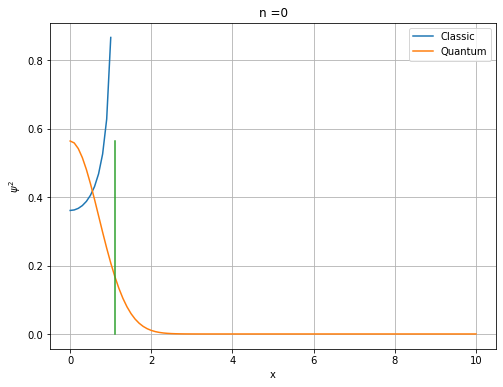

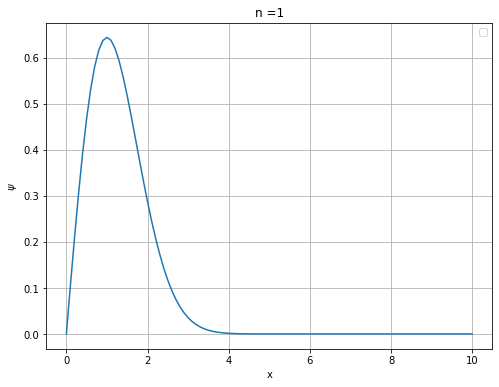

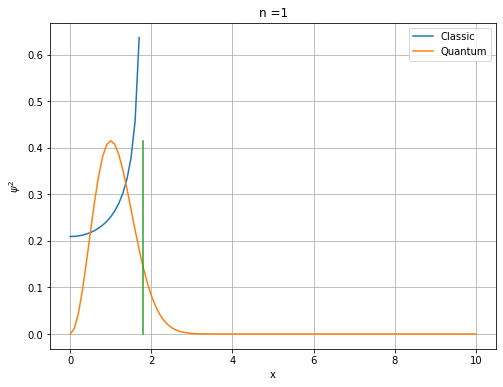

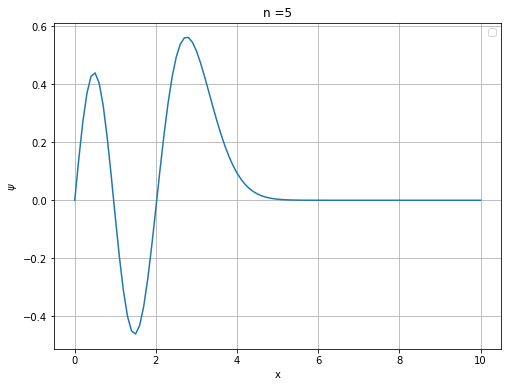

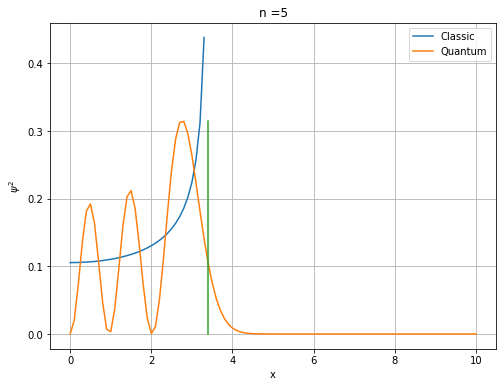

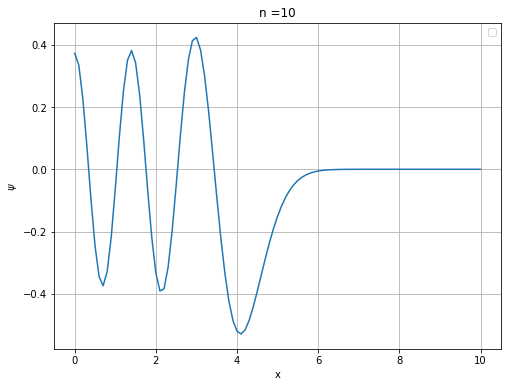

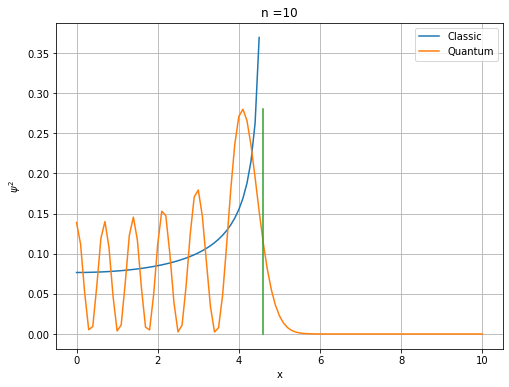

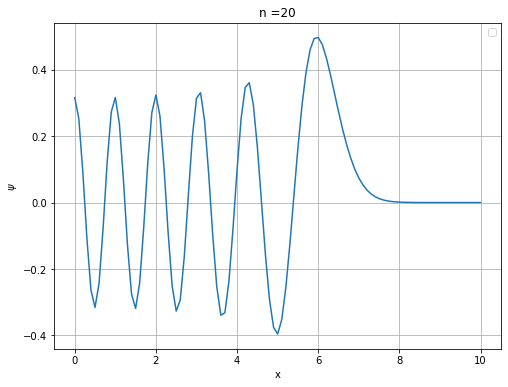

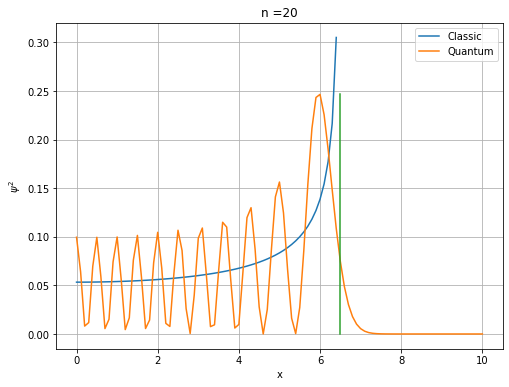

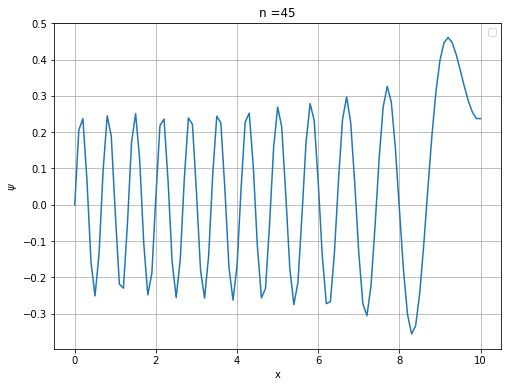

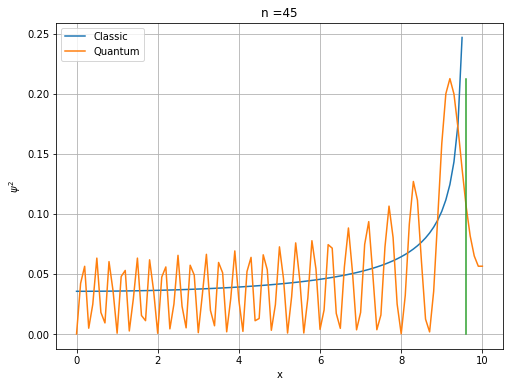

In [439]:
for i in range(len(nodes)):
    plt.figure(figsize = (8, 6))
    plt.title('n ='+str(nodes[i]))
    plt.plot(x_1[i], y_1[i])
    plt.xlabel('x')
    plt.ylabel('$\psi$')
    plt.grid()
    plt.legend()
    
    turnIndex = turnPoint(x=x_1[i], energy=energy_1[i], potential=string)
    psi_class = np.array([1/((-x_1[i][j]**2+x_1[i][turnIndex]**2)**0.5) for j in range(turnIndex)])
    psi_classical = normalizeWF(np.power(psi_class, 0.5), x_1[i][2]-x_1[i][1])
    plt.figure(figsize = (8, 6))
    plt.title('n ='+str(nodes[i]))
    plt.plot(x_1[i][:turnIndex], np.power(psi_classical, 2), label = 'Classic')
    plt.plot(x_1[i], np.power(y_1[i], 2), label = 'Quantum')
    plt.xlabel('x')
    plt.ylabel('$\psi^2$')
    plt.grid()
    y_2 = np.power(y_1[i], 2)
    plt.plot([x_1[i][turnIndex]]*len(np.linspace(min(y_2), max(y_2), 2)), np.linspace(min(y_2), max(y_2), 2))
    plt.legend()

## Задание 2. 

In [189]:
xmax = 10
nmax = 100
numNodes = 0
trialEnergy = 6.2
energy, x, y = bisectionIm(xmax=xmax, nmax=nmax, numNodes=numNodes, trialEnergy=trialEnergy)

Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity
         1	6.2000000000	         3
Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity


(-3, 2)

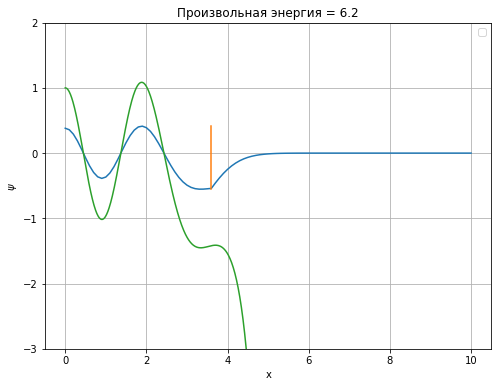

In [193]:
plt.figure(figsize = (8, 6))
plt.title('Произвольная энергия = 6.2')
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('$\psi$')
turnIndex = turnPoint(x=x, energy=energy, potential=string)
plt.plot([x[turnIndex]]*len(np.linspace(min(y), max(y), 4)), np.linspace(min(y), max(y), 4))
plt.grid()
plt.legend()
#plt.savefig('n = '+str(numNodes)+'_psi')
x_1, y_1 = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1300000000000001, 1.1400000000000001, 1.1500000000000001, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.3800000000000001, 1.3900000000000001, 1.4000000000000001, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.6300000000000001, 1.6400000000000001, 1.6500000000000001, 1.6600000000000001, 1.67, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.8800000000000001, 1.8900000000000001, 1.9000000000000001, 1.9100000000000001, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0, 2.0100000000000002, 2.02, 2.0300000000000002, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.1, 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.2, 2.21, 2.22, 2.23, 2.24, 2.25, 2.2600000000000002, 2.27, 2.2800000000000002, 2.29, 2.3000000000000003, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.5100000000000002, 2.52, 2.5300000000000002, 2.54, 2.5500000000000003, 2.56, 2.57, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7, 2.71, 2.72, 2.73, 2.74, 2.75, 2.7600000000000002, 2.77, 2.7800000000000002, 2.79, 2.8000000000000003, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.0, 3.0100000000000002, 3.02, 3.0300000000000002, 3.04, 3.0500000000000003, 3.06, 3.0700000000000003, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21, 3.22, 3.23, 3.24, 3.25, 3.2600000000000002, 3.27, 3.2800000000000002, 3.29, 3.3000000000000003, 3.31, 3.3200000000000003, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.5100000000000002, 3.52, 3.5300000000000002, 3.54, 3.5500000000000003, 3.56, 3.5700000000000003, 3.58, 3.59, 3.6, 3.61, 3.62, 3.63, 3.64, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7, 3.71, 3.72, 3.73, 3.74, 3.75, 3.7600000000000002, 3.77, 3.7800000000000002, 3.79, 3.8000000000000003, 3.81, 3.8200000000000003, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.89, 3.9, 3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.0, 4.01, 4.0200000000000005, 4.03, 4.04, 4.05, 4.0600000000000005, 4.07, 4.08, 4.09, 4.1, 4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18, 4.19, 4.2, 4.21, 4.22, 4.23, 4.24, 4.25, 4.26, 4.2700000000000005, 4.28, 4.29, 4.3, 4.3100000000000005, 4.32, 4.33, 4.34, 4.3500000000000005, 4.36, 4.37, 4.38, 4.39, 4.4, 4.41, 4.42, 4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.5, 4.51, 4.5200000000000005, 4.53, 4.54, 4.55, 4.5600000000000005, 4.57, 4.58, 4.59, 4.6000000000000005, 4.61, 4.62, 4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.7, 4.71, 4.72, 4.73, 4.74, 4.75, 4.76, 4.7700000000000005, 4.78, 4.79, 4.8, 4.8100000000000005, 4.82, 4.83, 4.84, 4.8500000000000005, 4.86, 4.87, 4.88, 4.89, 4.9, 4.91, 4.92, 4.93, 4.94, 4.95, 4.96, 4.97, 4.98, 4.99, 5.0, 5.01, 5.0200000000000005, 5.03, 5.04, 5.05, 5.0600000000000005, 5.07, 5.08, 5.09, 5.1000000000000005, 5.11, 5.12, 5.13, 5.14, 5.15, 5.16, 5.17, 5.18, 5.19, 5.2, 5.21, 5.22, 5.23, 5.24, 5.25, 5.26, 5.2700000000000005, 5.28, 5.29, 5.3, 5.3100000000000005, 5.32, 5.33, 5.34, 5.3500000000000005, 5.36, 5.37, 5.38, 5.39, 5.4, 5.41, 5.42, 5.43, 5.44, 5.45, 5.46, 5.47, 5.48, 5.49, 5.5, 5.51, 5.5200000000000005, 5.53, 5.54, 5.55, 5.5600000000000005, 5.57, 5.58, 5.59, 5.6000000000000005, 5.61, 5.62, 5.63, 5.64, 5.65, 5.66, 5.67, 5.68, 5.69, 5.7, 5.71, 5.72, 5.73, 5.74, 5.75, 5.76, 5.7700000000000005, 5.78, 5.79, 5.8, 5.8100000000000005, 5.82, 5.83, 5.84, 5.8500000000000005, 5.86, 5.87, 5.88, 5.89, 5.9, 5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 6.0, 6.01, 6.0200000000000005, 6.03, 6.04, 6.05, 6.0600000000000005, 6.07, 6.08, 6.09, 6.1000000000000005, 6.11, 6.12, 6.13, 6.140000000000001, 6.15, 6.16, 6.17, 6.18, 6.19, 6.2, 6.21, 6.22, 6.23, 6.24, 6.25, 6.26, 6.2700000000000005, 6.28, 6.29, 6.3, 6.3100000000000005, 6.32, 6.33, 6.34, 6.3500000000000005, 6.36, 6.37, 6.38, 6.390000000000001, 6.4, 6.41, 6.42, 6.43, 6.44, 6.45, 6.46, 6.47, 6.48, 6.49, 6.5, 6.51, 6.5200000000000005, 6.53, 6.54, 6.55, 6.5600000000000005, 6.57, 6.58, 6.59, 6.6000000000000005, 6.61, 6.62, 6.63, 6.640000000000001, 6.65, 6.66, 6.67, 6.68, 6.69, 6.7, 6.71, 6.72, 6.73, 6.74, 6.75, 6.76, 6.7700000000000005, 6.78, 6.79, 6.8, 6.8100000000000005, 6.82, 6.83, 6.84, 6.8500000000000005, 6.86, 6.87, 6.88, 6.890000000000001, 6.9, 6.91, 6.92, 6.93, 6.94, 6.95, 6.96, 6.97, 6.98, 6.99, 7.0, 7.01, 7.0200000000000005, 7.03, 7.04, 7.05, 7.0600000000000005, 7.07, 7.08, 7.09, 7.1000000000000005, 7.11, 7.12, 7.13, 7.140000000000001, 7.15, 7.16, 7.17, 7.18, 7.19, 7.2, 7.21, 7.22, 7.23, 7.24, 7.25, 7.26, 7.2700000000000005, 7.28, 7.29, 7.3, 7.3100000000000005, 7.32, 7.33, 7.34, 7.3500000000000005, 7.36, 7.37, 7.38, 7.390000000000001, 7.4, 7.41, 7.42, 7.43, 7.44, 7.45, 7.46, 7.47, 7.48, 7.49, 7.5, 7.51, 7.5200000000000005, 7.53, 7.54, 7.55, 7.5600000000000005, 7.57, 7.58, 7.59, 7.6000000000000005, 7.61, 7.62, 7.63, 7.640000000000001, 7.65, 7.66, 7.67, 7.68, 7.69, 7.7, 7.71, 7.72, 7.73, 7.74, 7.75, 7.76, 7.7700000000000005, 7.78, 7.79, 7.8, 7.8100000000000005, 7.82, 7.83, 7.84, 7.8500000000000005, 7.86, 7.87, 7.88, 7.890000000000001, 7.9, 7.91, 7.92, 7.930000000000001, 7.94, 7.95, 7.96, 7.97, 7.98, 7.99, 8.0, 8.01, 8.02, 8.03, 8.040000000000001, 8.05, 8.06, 8.07, 8.08, 8.09, 8.1, 8.11, 8.120000000000001, 8.13, 8.14, 8.15, 8.16, 8.17, 8.18, 8.19, 8.2, 8.21, 8.22, 8.23, 8.24, 8.25, 8.26, 8.27, 8.28, 8.290000000000001, 8.3, 8.31, 8.32, 8.33, 8.34, 8.35, 8.36, 8.370000000000001, 8.38, 8.39, 8.4, 8.41, 8.42, 8.43, 8.44, 8.45, 8.46, 8.47, 8.48, 8.49, 8.5, 8.51, 8.52, 8.53, 8.540000000000001, 8.55, 8.56, 8.57, 8.58, 8.59, 8.6, 8.61, 8.620000000000001, 8.63, 8.64, 8.65, 8.66, 8.67, 8.68, 8.69, 8.700000000000001, 8.71, 8.72, 8.73, 8.74, 8.75, 8.76, 8.77, 8.78, 8.790000000000001, 8.8, 8.81, 8.82, 8.83, 8.84, 8.85, 8.86, 8.870000000000001, 8.88, 8.89, 8.9, 8.91, 8.92, 8.93, 8.94, 8.950000000000001, 8.96, 8.97, 8.98, 8.99, 9.0, 9.01, 9.02, 9.03, 9.040000000000001, 9.05, 9.06, 9.07, 9.08, 9.09, 9.1, 9.11, 9.120000000000001, 9.13, 9.14, 9.15, 9.16, 9.17, 9.18, 9.19, 9.200000000000001, 9.21, 9.22, 9.23, 9.24, 9.25, 9.26, 9.27, 9.28, 9.290000000000001, 9.3, 9.31, 9.32, 9.33, 9.34, 9.35, 9.36, 9.370000000000001, 9.38, 9.39, 9.4, 9.41, 9.42, 9.43, 9.44, 9.450000000000001, 9.46, 9.47, 9.48, 9.49, 9.5, 9.51, 9.52, 9.53, 9.540000000000001, 9.55, 9.56, 9.57, 9.58, 9.59, 9.6, 9.61, 9.620000000000001, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68, 9.69, 9.700000000000001, 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.790000000000001, 9.8, 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.870000000000001, 9.88, 9.89, 9.9, 9.91, 9.92, 9.93, 9.94, 9.950000000000001, 9.96, 9.97, 9.98, 9.99, 10.0], [1.0, 0.9993800648927775, 0.9975210381977895, 0.9944252547553412, 0.9900966025016926, 0.9845405172780124, 0.9777639755735578, 0.9697754852137064, 0.9605850740064567, 0.9502042763640303, 0.9386461179191293, 0.9259250981583448, 0.9120571710981086, 0.8970597240314078, 0.8809515543763016, 0.8637528446600165, 0.8454851356751105, 0.8261712978468166, 0.8058355008532627, 0.7845031815427698, 0.7622010101948671, 0.738956855174021, 0.7147997460273623, 0.689759835079897, 0.6638683575827916, 0.6371575904723661, 0.6096608097993415, 0.5814122468897438, 0.552447043300598, 0.5228012046351855, 0.4925115532841789, 0.46161568016040083, 0.43015189549627136, 0.39815917877422624, 0.3656771278614991, 0.3327459074216414, 0.2994061966760432, 0.2656991365894686, 0.23166627655427968, 0.1973495206485471, 0.16279107354365932, 0.12803338613734158, 0.09311910098817433, 0.05809099762776193, 0.022991937826649936, -0.012135189110085588, -0.04724752094193724, -0.08230227691151895, -0.1172568119078526, -0.15206867030029764, -0.18669563936977274, -0.22109580226477013, -0.25522759041061616, -0.2890498353015005, -0.3225218196059584, -0.35560332751775986, -0.3882546942855286, -0.4204368548558737, -0.45211139156637675, -0.4832405808264199, -0.5137874387255781, -0.5437157655111146, -0.5729901888780217, -0.601576206017018, -0.6294402243679799, -0.6565496010283798, -0.6828726807685189, -0.7083788326075694, -0.7330384849067618, -0.7568231589384081, -0.7797055008918743, -0.8016593122800564, -0.8226595787124424, -0.8426824970033497, -0.8617055005865268, -0.8797072832098984, -0.8966678208868469, -0.9125683920830975, -0.9273915961209138, -0.9411213697849905, -0.9537430021171157, -0.9652431473893588, -0.9756098362482132, -0.9848324850248183, -0.9929019032090396, -0.9998102990878279, -1.005551283550955, -1.0101198720697706, -1.01351248485729, -1.015726945220396, -1.0167624761175307, -1.0166196949376891, -1.0153006065189814, -1.0128085944274383, -1.0091484105190769, -1.0043261628105182, -0.9983493016857232, -0.991226604468554, -0.9829681583930358, -0.9735853420052021, -0.9630908050324222, -0.9514984467580165, -0.9388233929408226, -0.9250819713211291, -0.9102916857560982, -0.8944711890294017, -0.8776402543813623, -0.8598197458072883, -0.8410315871731109, -0.8212987301986768, -0.8006451213602697, -0.7790956677650185, -0.7566762020508848, -0.7334134463668416, -0.7093349754886956, -0.684469179126747, -0.6588452234821472, -0.6324930121093628, -0.605443146142639, -0.5777268839447377, -0.5493761002365061, -0.5204232447660326, -0.4909013005762737, -0.4608437419300241, -0.43028449195107116, -0.39925788004018914, -0.36779859912440765, -0.3359416627976477, -0.30372236241042017, -0.27117622416578435, -0.23833896627819542, -0.20524645625121168, -0.17193466832931578, -0.13843964117829372, -0.10479743584774495, -0.07104409406835129, -0.037215596935518604, -0.0033478240299264074, 0.030523486975619955, 0.064362780174845, 0.09813472070523672, 0.13180423339824573, 0.16533654075820517, 0.19869720022714843, 0.2318521406941667, 0.2647676982094595, 0.29741065086478446, 0.3297482528036015, 0.3617482673258333, 0.39337899905382634, 0.4246093251277792, 0.45540872540062294, 0.4857473116040748, 0.5155958554593485, 0.544925815707773, 0.5737093640383722, 0.601919409891249, 0.6295296241174344, 0.6565144614776773, 0.6828491819644623, 0.708509870933373, 0.733473458031715, 0.7577177349141431, 0.7812213717368195, 0.8039639324234258, 0.825925888698124, 0.8470886328823297, 0.8674344894538754, 0.8869467253688895, 0.9056095591483864, 0.9234081687332403, 0.9403286981128569, 0.9563582627344517, 0.9714849537014398, 0.9856978407709616, 0.9989869741620871, 1.0113433851876994, 1.0227590857244933, 1.0332270665368959, 1.0427412944720673, 1.0512967085444394, 1.0588892149294733, 1.0655156808875668, 1.0711739276401526, 1.075862722221159, 1.0795817683280526, 1.082331696197682, 1.084114051533108, 1.0849312835084857, 1.0847867318799183, 1.0836846132310092, 1.0816300063825486, 1.07862883699648, 1.0746878614049122, 1.0698146496955143, 1.0640175680851616, 1.0573057606141543, 1.049689130193755, 1.0411783190401391, 1.0317846885281643, 1.0215202984986176, 1.0103978860527858, 0.9984308438683535, 0.9856331980707176, 0.9720195856938744, 0.957605231764987, 0.9424059260467337, 0.9264379994714061, 0.9097183003005817, 0.8922641700440087, 0.8740934191710833, 0.8552243026480404, 0.8356754953336202, 0.8154660672656363, 0.7946154588704388, 0.7731434561268323, 0.7510701657155218, 0.7284159901846337, 0.7052016031613202, 0.6814479246388436, 0.6571760963679465, 0.6324074573806456, 0.607163519673917, 0.5814659440800365, 0.5553365163496174, 0.5287971234726171, 0.5018697302618329, 0.4745763562225967, 0.4469390527315695, 0.41897988054671026, 0.3907208876696383, 0.36218408758076004, 0.33339143786664577, 0.30436481925826875, 0.27512601509782, 0.24569669125091284, 0.21609837648008526, 0.18635244329459671, 0.15648008929059776, 0.12650231899483583, 0.09643992622414396, 0.06631347697204101, 0.03614329283285771, 0.005949434972893066, -0.02424831134280213, -0.0544304516603156, -0.08457779667663211, -0.11467147600333845, -0.14469295134922722, -0.17462402911761504, -0.20444687241504136, -0.23414401246885658, -0.26369835945202813, -0.2930932127143038, -0.32231227041967403, -0.35133963859083905, -0.3801598395621598, -0.4087578198433101, -0.43711895739656487, -0.4652290683313792, -0.4930744130205816, -0.5206417016431756, -0.5479180991593927, -0.5748912297242478, -0.6015491805464622, -0.6278805052001872, -0.6538742263975094, -0.6795198382302798, -0.7048073078902699, -0.7297270768771922, -0.7542700617045492, -0.7784276541137249, -0.8021917208071474, -0.8255546027117416, -0.8485091137842534, -0.871048539370373, -0.8931666341298992, -0.9148576195404837, -0.9361161809927733, -0.9569374644900034, -0.9773170729653415, -0.9972510622304406, -1.016735936568906, -1.0357686439884835, -1.0543465711459301, -1.0724675379586597, -1.090129791917324, -1.107332002113573, -1.1240732529973105, -1.140353037877755, -1.1561712521826664, -1.1715281864900744, -1.1864245193468246, -1.20086130988823, -1.2148399902730433, -1.2283623579478866, -1.2414305677552107, -1.2540471238987263, -1.2662148717801418, -1.2779369897208974, -1.289216980582453, -1.3000586632985094, -1.3104661643323823, -1.3204439090725661, -1.329996613179312, -1.3391292738948568, -1.3478471613297107, -1.3561558097372142, -1.3640610087882896, -1.3715687948581337, -1.3786854423363126, -1.3854174549714706, -1.391771557261619, -1.3977546859006933, -1.4033739812918191, -1.408636779137413, -1.4135506021160145, -1.4181231516554507, -1.4223622998116425, -1.4262760812620905, -1.4298726854227983, -1.433160448697117, -1.436147846864681, -1.4388434876183638, -1.4412561032568665, -1.4433945435403135, -1.4452677687159123, -1.4468848427204997, -1.4482549265664966, -1.449387271917566, -1.4502912148599714, -1.450976169875394, -1.4514516240207471, -1.451727131320218, -1.4518123073745948, -1.4517168241926763, -1.4514504052493384, -1.4510228207746276, -1.4504438832780333, -1.449723443311905, -1.4488713854777917, -1.4478976246792712, -1.4468121026247158, -1.4456247845832333, -1.4443456563969, -1.4429847217522545, -1.4415519997138824, -1.4400575225228232, -1.4385113336624118, -1.4369234861940563, -1.4353040413654137, -1.4336630674933057, -1.4320106391237037, -1.4303568364710277, -1.4287117451389941, -1.4270854561252335, -1.425488066111883, -1.423929678044363, -1.4224204020005913, -1.4209703563529106, -1.419589669225061, -1.4182884802466018, -1.4170769426072816, -1.4159652254139257, -1.414963516352553, -1.4140820246585653, -1.4133309843979858, -1.412720658062906, -1.4122613404844715, -1.4119633630669621, -1.4118370983467052, -1.4118929648798453, -1.4121414324632118, -1.412593027692825, -1.413258339864879, -1.4141480272243552, -1.4152728235667584, -1.416643545198835, -1.4182710982645037, -1.4201664864426617, -1.4223408190239275, -1.4248053193738646, -1.4275713337906866, -1.4306503407659792, -1.4340539606574714, -1.437793965783477, -1.441882290949197, -1.4463310444157098, -1.451152519323101, -1.4563592055798826, -1.461963802231557, -1.4679792303219266, -1.4744186462615232, -1.4812954557183782, -1.4886233280471577, -1.4964162112736434, -1.5046883476524218, -1.5134542898166645, -1.5227289175398726, -1.5325274551305517, -1.5428654894818796, -1.5537589887996304, -1.565224322032795, -1.5772782790326465, -1.5899380914673258, -1.6032214545204104, -1.6171465494033765, -1.631732066713407, -1.6469972306695717, -1.6629618242620667, -1.679646215350944, -1.6970713837525828, -1.7152589493540327, -1.7342312012973444, -1.7540111282781123, -1.7746224500045664, -1.7960896498658652, -1.818438008860593, -1.8416936408389382, -1.8658835291146558, -1.891035564505593, -1.9171785848644332, -1.9443424161642588, -1.972557915206684, -2.0018570140235212, -2.0322727660463937, -2.0638393941222715, -2.0965923404566262, -2.130568318569853, -2.1658053673567075, -2.202342907342761, -2.2402217992364606, -2.279484404880039, -2.3201746507074943, -2.3623380938230523, -2.4060219908189526, -2.4512753694570977, -2.498149103345115, -2.546695989743606, -2.5969708306479613, -2.6490305172950372, -2.7029341182521778, -2.758742971253725, -2.816520778958063, -2.8763337088066647, -2.9382504971753387, -3.002342558017128, -3.0686840962059736, -3.1373522258003983, -3.2084270934571624, -3.281992007236003, -3.358133571048374, -3.436941825015438, -3.518510392013549, -3.6029366306991024, -3.690321795318943, -3.7807712026276095, -3.874394406248502, -3.9713053788326755, -4.071622702386467, -4.175469767157563, -4.282974979488374, -4.394271979065928, -4.509499866018906, -4.628803438334816, -4.7523334400940325, -4.880246821042158, -5.012707008048452, -5.149884189025449, -5.291955609913898, -5.439105885367595, -5.591527323804706, -5.749420267525881, -5.912993448635052, -6.082464361536013, -6.258059652817372, -6.440015529379716, -6.628578185702572, -6.824004251194586, -7.026561258618665, -7.236528134634742, -7.454195713556587, -7.679867275475361, -7.913859109962262, -8.156501106625372, -8.408137373861654, -8.669126887214887, -8.939844168823566, -9.220679999520165, -9.512042165224669, -9.814356239361071, -10.128066403116259, -10.453636305456097, -10.791549964914246, -11.142312715275395, -11.506452197386448, -11.88451939944753, -12.277089748259003, -12.684764254032164, -13.108170711509922, -13.547964960289885, -14.004832207396712, -14.4794884153134, -14.972681758852856, -15.48519415443278, -16.017842865507973, -16.571482188116427, -17.147005220709, -17.745345722657614, -18.36748006607458, -19.014429285827248, -19.687261232896862, -20.387092836511297, -21.115092480776617, -21.872482501845454, -22.660541811990242, -23.480608657298305, -24.334083516074557, -25.222432145427003, -26.14718878392222, -27.109959518633037, -28.112425825360702, -29.156348291300358, -30.243570529932295, -31.376023298465523, -32.55572882873484, -33.78480538306036, -35.06547204722141, -36.400053773376946, -37.79098668648345, -39.24082366852237, -40.75224023565458, -42.3280407242704, -43.971164802805674, -45.68469432714789, -47.471860558465956, -49.33605176336625, -51.28082121740764, -53.30989563420643, -55.427184043630106, -57.6367871439204, -59.943007154008264, -62.350358193788836, -64.86357722171823, -67.48763556078406, -70.22775104568922, -73.08940082598498, -76.07833486189713, -79.20059015171643, -82.46250573188013, -85.870738493261, -89.4322798597126, -93.15447337760513, -97.04503326793169, -101.11206399558255, -105.36408091358481, -109.8100320434965, -114.45932105674284, -119.32183152549685, -124.40795251575514, -129.7286055995508, -135.2952733678022, -141.1200295301259, -147.21557069307013, -153.59524991366698, -160.27311213097167, -167.26393158438887, -174.58325133408962, -182.2474250057253, -190.27366088897676, -198.68006852726165, -207.48570794418208, -216.71064166107755, -226.37598966936017, -236.5039875312169, -247.1180477927718, -258.242824904978, -269.9042838593696, -282.12977275842144, -294.94809955365844, -308.3896131988971, -322.486289481136, -337.27182180769825, -352.78171724532785, -369.0533981251181, -386.12630954648347, -404.0420331339263, -422.8444074222157, -442.57965526882725, -463.29651871721313, -485.0464017607675, -507.88352148532033, -531.8650680977514, -557.0513743799718, -583.506095141219, -611.2963972774559, -640.4931610848245, -671.171193514719, -703.4094541012674, -737.2912943380439, -772.9047113298279, -810.3426165973947, -849.7031209688951, -891.089836550529, -934.612196832249, -980.3857960513518, -1028.5327490083082, -1079.182072605375, -1132.470090459695, -1188.5408620290582, -1247.5466377806904, -1309.648342031637, -1375.0160851940145, -1443.8297072700104, -1516.2793545604484, -1592.5660916776274, -1672.9025510883432, -1757.5136225572462, -1846.6371850144874, -1940.5248835356304, -2039.4429542967948, -2143.6731005546526, -2253.513422899997, -2369.2794072461033, -2491.3049742397725, -2619.943594024898, -2755.5694705466117, -2898.5787998595783, -3049.391107198291, -3208.4506678811613, -3376.228017455558, -3553.2215568489178, -3739.959258673359, -3937.000481239471, -4144.937897271062, -4364.399544778307, -4596.05100804442, -4840.597737212395, -5098.787515526425, -5371.4130838893625, -5659.314933046189, -5963.3842743965315, -6284.566201180134, -6623.863052570989, -6982.337994062575, -7361.118828431653, -7761.402052535909, -8184.4571762356045, -8631.631320836252, -9104.354115633032, -9604.142912403913, -10132.60833905289, -10691.460215053965, -11282.51385289699, -11907.696771395527, -12569.055848492515, -13268.764943099563, -14009.13301753994, -14792.612794342085, -15621.809983461819, -16499.493118506452, -17428.604043206553, -18412.269092241982, -19453.811013593884, -20556.76168287609, -21724.875663615276, -22962.144671215578, -24272.813002378458, -25661.393996071958, -27132.687596776228, -28691.799095697323, -30344.15913096213, -32095.545033511033, -33952.10361151863, -35920.37547272805, -38007.32099111145, -40220.3480318054, -42567.34155635044, -45056.69523893109, -47697.34523360832, -50498.80624250713, -53471.21004561914, -56625.34666435708, -59972.70834331123, -63525.5365478726, -67296.87218956863, -71300.60930617696, -75551.55244002155, -80065.47797539193, -84859.19971485608, -89950.63899445339, -95358.8996594618, -101104.34824574605, -107208.69973673191, -113695.1092929412, -120588.27037991417, -127914.51975137813, -135701.94977786485, -143980.52864680922, -152782.22899866075, -162141.16560492013, -172093.74273848368, -182678.8119344861, -193937.840891223, -205915.09431598563, -218657.82758005222, -232216.49411095932, -246644.96751888274, -262000.77952784512, -278345.37486195174, -295744.3843223494, -314267.91738259286, -333990.8757290644, -354993.28927959147, -377360.67632801103, -401184.4295857637, -426562.2300243666, -453598.4905655162, -482404.8318194224, -513100.5922376166, -545813.3752248315, -580679.6359466176, -617845.3107762057, -657466.4925469137, -699710.155016378, -744754.9302074168, -792791.9425688575, -844025.7041997715, -898675.0757039523, -956974.2975899869, -1019174.097507895, -1085542.8790181952, -1156367.9980257102, -1231957.1334809794, -1312639.7594594853, -1398768.7262759719, -1490721.9588810864, -1588904.2814238695, -1693749.377549909, -1805721.896745294, -1925319.7178351828, -2053076.3816074873, -2189563.7054619845, -2335394.5939885653, -2491226.0604611365, -2657762.4754025275, -2835759.059637374, -3026025.640611883, -3229430.692229884, -3446905.680042246, -3679449.7353412583, -3928134.6835631547, -4194110.454401743, -4478610.903196267, -4782960.075490059, -5108578.949177679, -5456992.691382064, -5829838.470146688, -6228873.864208556, -6655985.91755568, -7113200.889188663, -7602694.752522821, -8126804.503209918, -8688040.338853776, -9289098.779171031, -9932876.800638517, -10622487.06560656, -11361274.33227974, -12152833.138913954, -13001026.863094203, -13910008.265088808, -14884241.633074142, -15928526.657544892, -17048024.172528856, -18248283.91237767, -19535274.444976714, -20915415.45528581, -22395612.567270808, -23983294.90760575, -25686455.63111385, -27513695.645881098, -29474270.795433417, -31578142.77644405, -33836034.09326978, -36259487.37534806, -38860929.41028802, -41653740.274528, -44652327.974902615, -47872209.048570536, -51330095.60572375, -55043989.33957426, -59033283.071560815, -63318870.44682356, -67923264.44607168, -72870725.43535854, -78187399.53535132, -83901468.15683761, -90043309.61988929, -96645673.85077788, -103743871.23392296, -111375976.78641897, -119583050.92063513, -128409378.16668388, -137902725.34193158, -148114620.77996022, -159100656.36734658, -170920814.28422928, -183639820.50489965, -197327527.2886891, -212059327.0804204, -227916600.444967, -244987200.8834296, -263365979.62065703, -283155353.7169787, -304465921.14293224, -327417126.76644963, -352137983.5395895, -378767853.5388528, -407457293.9119622, -438368973.21755666, -471678664.11560273, -507576318.8788058, -546267234.7525605, -587973316.7969775, -632934446.5035774, -681409965.1961064, -733680282.0046959, -790048617.0509008, -850842891.4041147, -916417776.374114, -987156915.7973534, -1063475336.1639718, -1145822060.7270005, -1234682945.144366, -1330583753.738264, -1434093497.126607, -1545828053.799676, -1666454100.195377, -1796693375.9829726, -1937327313.614028, -2089202063.7577248, -2253233951.0247903, -2430415397.420768, -2621821354.277765, -2828616287.0189567, -3052061761.038997, -3293524681.26546, -3554486242.6338468, -3836551653.796594, -4141460701.9334574, -4471099232.578506, -4827511624.973705, -5212914350.650759, -5629710710.786473, -6080506856.432101, -6568129205.049563, -7095643376.968681, -7666374786.487766, -8283931034.460912, -8952226262.44243, -9675507642.8947, -10458384195.721931, -11305858138.591976, -12223358997.284458, -13216780722.803791, -14292522084.379555, -15457530631.92056, -16719350548.18383, -18086174740.077286, -19566901550.363804, -21171196505.82734, -22909559555.97501, -24793398297.883183, -26835107728.18273, -29048157112.78053, -31447184619.12644, -34048100415.09384, -36868199003.321815, -39926281630.68909, -43242789690.028015, -46839950115.86279, -50741933868.559746, -54975028702.557686, -59567827525.12957, -64551433773.31267, -69959685369.22763, -75829398959.06969, -82200636299.78746, -89116994831.17616, -96625924661.22885, -104779074400.68338, -113632668510.49757, -123247919075.36992, -133691475189.46544, -145035913439.4891, -157360273297.6598, -170750641595.71893, -185300790643.8641, -201112874988.72818, -218298192275.85126, -236978014198.48895, -257284494080.43326, -279361658260.5887, -303366489126.59814, -329470108389.646, -357859070009.01697, -388736773070.0434, -422325005900.3786, -458865633785.5275, -498622443824.4751, -541883161760.26825, -588961657039.6647, -640200353912.7819, -695972868091.511, -756686890359.1753, -822787340579.8098, -894759817811.4359, -973134374703.5469, -1058489647076.3745, -1151457372562.2275, -1252727335463.5405, -1363052778577.0435, -1483256326680.4924, -1614236470712.5352, -1756974666436.0503, -1912543106602.888, -2082113231380.0234, -2266965048104.844, -2468497338367.136, -2688238838029.281, -2927860484162.7275, -3189188832073.1416, -3474220755691.636, -3785139555716.605, -4124332612100.174, -4494410730896.242, -4898229350245.252, -5338911786498.726, -5819874719332.449, -6344856134323.928, -6917945963057.452, -7543619684567.114, -8226775178052.442, -8972773145544.494, -9787481454827.29, -10677323787723.436, -11649333017156.36, -12711209778561.068, -13871386747623.104, -15139099187414.395, -16524462384243.621, -18038556653473.113, -19693520664757.215, -21502653911269.02, -23480529230212.07, -25643116373042.05, -28007917724214.05, -30594117377873.87, -33422744903780.94, -36516855268043.125, -39901726522243.03, -43605077037656.414, -47657304241066.91, -52091747006895.06, -56944974078888.11, -62257101135567.56, -68072139379329.555, -74438378822108.83, -81408809763692.58, -89041586315241.88, -97400536213818.58, -106555721607555.84, -116584055969790.34, -127569982828683.66, -139606222581773.27, -152794594308247.38, -167246920201861.25, -183086021031319.38, -200446811900379.78, -219477508535474.78, -240340955383769.4, -263216087969777.22, -288299543245556.6, -315807433090935.8, -345977297690418.9, -379070257248102.25, -415373382418544.5, -455202305949341.25, -498904100371510.75, -546860449160358.8, -599491141648411.0, -657257925132300.9, -720668751109252.2, -790282456441610.8, -866713924519111.5, -950639776211898.9, -1042804645631109.8, -1144028101491624.5, -1255212281262888.2, -1377350312364162.0, -1511535602483310.8]
plt.plot(x_1, y_1)
plt.ylim(-3, 2)

Здесь мы видим большой излом производной в т. поворота для harmonic1. В отличие от harmonic0 волновая функция убывает при больших х, за счет установленных нами граничных условий во второй части сетки. 

In [196]:
xmax = 10
nmax = 100
numNodes = 0
trialEnergy = 6.45
energy, x, y = bisectionIm(xmax=xmax, nmax=nmax, numNodes=numNodes, trialEnergy=trialEnergy)

Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity
         1	6.4500000000	         3
Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity


(-3, 2)

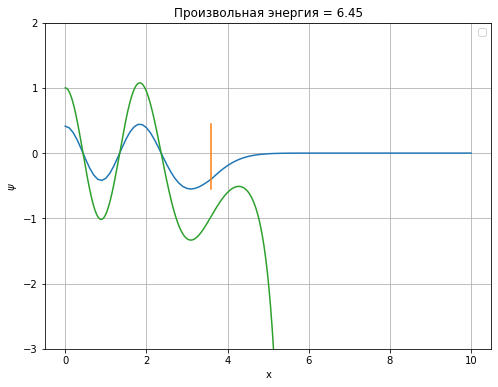

In [201]:
plt.figure(figsize = (8, 6))
plt.title('Произвольная энергия = 6.45')
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('$\psi$')
turnIndex = turnPoint(x=x, energy=energy, potential=string)
plt.plot([x[turnIndex]]*len(np.linspace(min(y), max(y), 4)), np.linspace(min(y), max(y), 4))
plt.grid()
plt.legend()
#plt.savefig('n = '+str(numNodes)+'_psi')
x_1, y_1 = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1300000000000001, 1.1400000000000001, 1.1500000000000001, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.3800000000000001, 1.3900000000000001, 1.4000000000000001, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.6300000000000001, 1.6400000000000001, 1.6500000000000001, 1.6600000000000001, 1.67, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.8800000000000001, 1.8900000000000001, 1.9000000000000001, 1.9100000000000001, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0, 2.0100000000000002, 2.02, 2.0300000000000002, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.1, 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.2, 2.21, 2.22, 2.23, 2.24, 2.25, 2.2600000000000002, 2.27, 2.2800000000000002, 2.29, 2.3000000000000003, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.5100000000000002, 2.52, 2.5300000000000002, 2.54, 2.5500000000000003, 2.56, 2.57, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7, 2.71, 2.72, 2.73, 2.74, 2.75, 2.7600000000000002, 2.77, 2.7800000000000002, 2.79, 2.8000000000000003, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.0, 3.0100000000000002, 3.02, 3.0300000000000002, 3.04, 3.0500000000000003, 3.06, 3.0700000000000003, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21, 3.22, 3.23, 3.24, 3.25, 3.2600000000000002, 3.27, 3.2800000000000002, 3.29, 3.3000000000000003, 3.31, 3.3200000000000003, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.5100000000000002, 3.52, 3.5300000000000002, 3.54, 3.5500000000000003, 3.56, 3.5700000000000003, 3.58, 3.59, 3.6, 3.61, 3.62, 3.63, 3.64, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7, 3.71, 3.72, 3.73, 3.74, 3.75, 3.7600000000000002, 3.77, 3.7800000000000002, 3.79, 3.8000000000000003, 3.81, 3.8200000000000003, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.89, 3.9, 3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.0, 4.01, 4.0200000000000005, 4.03, 4.04, 4.05, 4.0600000000000005, 4.07, 4.08, 4.09, 4.1, 4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18, 4.19, 4.2, 4.21, 4.22, 4.23, 4.24, 4.25, 4.26, 4.2700000000000005, 4.28, 4.29, 4.3, 4.3100000000000005, 4.32, 4.33, 4.34, 4.3500000000000005, 4.36, 4.37, 4.38, 4.39, 4.4, 4.41, 4.42, 4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.5, 4.51, 4.5200000000000005, 4.53, 4.54, 4.55, 4.5600000000000005, 4.57, 4.58, 4.59, 4.6000000000000005, 4.61, 4.62, 4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.7, 4.71, 4.72, 4.73, 4.74, 4.75, 4.76, 4.7700000000000005, 4.78, 4.79, 4.8, 4.8100000000000005, 4.82, 4.83, 4.84, 4.8500000000000005, 4.86, 4.87, 4.88, 4.89, 4.9, 4.91, 4.92, 4.93, 4.94, 4.95, 4.96, 4.97, 4.98, 4.99, 5.0, 5.01, 5.0200000000000005, 5.03, 5.04, 5.05, 5.0600000000000005, 5.07, 5.08, 5.09, 5.1000000000000005, 5.11, 5.12, 5.13, 5.14, 5.15, 5.16, 5.17, 5.18, 5.19, 5.2, 5.21, 5.22, 5.23, 5.24, 5.25, 5.26, 5.2700000000000005, 5.28, 5.29, 5.3, 5.3100000000000005, 5.32, 5.33, 5.34, 5.3500000000000005, 5.36, 5.37, 5.38, 5.39, 5.4, 5.41, 5.42, 5.43, 5.44, 5.45, 5.46, 5.47, 5.48, 5.49, 5.5, 5.51, 5.5200000000000005, 5.53, 5.54, 5.55, 5.5600000000000005, 5.57, 5.58, 5.59, 5.6000000000000005, 5.61, 5.62, 5.63, 5.64, 5.65, 5.66, 5.67, 5.68, 5.69, 5.7, 5.71, 5.72, 5.73, 5.74, 5.75, 5.76, 5.7700000000000005, 5.78, 5.79, 5.8, 5.8100000000000005, 5.82, 5.83, 5.84, 5.8500000000000005, 5.86, 5.87, 5.88, 5.89, 5.9, 5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 6.0, 6.01, 6.0200000000000005, 6.03, 6.04, 6.05, 6.0600000000000005, 6.07, 6.08, 6.09, 6.1000000000000005, 6.11, 6.12, 6.13, 6.140000000000001, 6.15, 6.16, 6.17, 6.18, 6.19, 6.2, 6.21, 6.22, 6.23, 6.24, 6.25, 6.26, 6.2700000000000005, 6.28, 6.29, 6.3, 6.3100000000000005, 6.32, 6.33, 6.34, 6.3500000000000005, 6.36, 6.37, 6.38, 6.390000000000001, 6.4, 6.41, 6.42, 6.43, 6.44, 6.45, 6.46, 6.47, 6.48, 6.49, 6.5, 6.51, 6.5200000000000005, 6.53, 6.54, 6.55, 6.5600000000000005, 6.57, 6.58, 6.59, 6.6000000000000005, 6.61, 6.62, 6.63, 6.640000000000001, 6.65, 6.66, 6.67, 6.68, 6.69, 6.7, 6.71, 6.72, 6.73, 6.74, 6.75, 6.76, 6.7700000000000005, 6.78, 6.79, 6.8, 6.8100000000000005, 6.82, 6.83, 6.84, 6.8500000000000005, 6.86, 6.87, 6.88, 6.890000000000001, 6.9, 6.91, 6.92, 6.93, 6.94, 6.95, 6.96, 6.97, 6.98, 6.99, 7.0, 7.01, 7.0200000000000005, 7.03, 7.04, 7.05, 7.0600000000000005, 7.07, 7.08, 7.09, 7.1000000000000005, 7.11, 7.12, 7.13, 7.140000000000001, 7.15, 7.16, 7.17, 7.18, 7.19, 7.2, 7.21, 7.22, 7.23, 7.24, 7.25, 7.26, 7.2700000000000005, 7.28, 7.29, 7.3, 7.3100000000000005, 7.32, 7.33, 7.34, 7.3500000000000005, 7.36, 7.37, 7.38, 7.390000000000001, 7.4, 7.41, 7.42, 7.43, 7.44, 7.45, 7.46, 7.47, 7.48, 7.49, 7.5, 7.51, 7.5200000000000005, 7.53, 7.54, 7.55, 7.5600000000000005, 7.57, 7.58, 7.59, 7.6000000000000005, 7.61, 7.62, 7.63, 7.640000000000001, 7.65, 7.66, 7.67, 7.68, 7.69, 7.7, 7.71, 7.72, 7.73, 7.74, 7.75, 7.76, 7.7700000000000005, 7.78, 7.79, 7.8, 7.8100000000000005, 7.82, 7.83, 7.84, 7.8500000000000005, 7.86, 7.87, 7.88, 7.890000000000001, 7.9, 7.91, 7.92, 7.930000000000001, 7.94, 7.95, 7.96, 7.97, 7.98, 7.99, 8.0, 8.01, 8.02, 8.03, 8.040000000000001, 8.05, 8.06, 8.07, 8.08, 8.09, 8.1, 8.11, 8.120000000000001, 8.13, 8.14, 8.15, 8.16, 8.17, 8.18, 8.19, 8.2, 8.21, 8.22, 8.23, 8.24, 8.25, 8.26, 8.27, 8.28, 8.290000000000001, 8.3, 8.31, 8.32, 8.33, 8.34, 8.35, 8.36, 8.370000000000001, 8.38, 8.39, 8.4, 8.41, 8.42, 8.43, 8.44, 8.45, 8.46, 8.47, 8.48, 8.49, 8.5, 8.51, 8.52, 8.53, 8.540000000000001, 8.55, 8.56, 8.57, 8.58, 8.59, 8.6, 8.61, 8.620000000000001, 8.63, 8.64, 8.65, 8.66, 8.67, 8.68, 8.69, 8.700000000000001, 8.71, 8.72, 8.73, 8.74, 8.75, 8.76, 8.77, 8.78, 8.790000000000001, 8.8, 8.81, 8.82, 8.83, 8.84, 8.85, 8.86, 8.870000000000001, 8.88, 8.89, 8.9, 8.91, 8.92, 8.93, 8.94, 8.950000000000001, 8.96, 8.97, 8.98, 8.99, 9.0, 9.01, 9.02, 9.03, 9.040000000000001, 9.05, 9.06, 9.07, 9.08, 9.09, 9.1, 9.11, 9.120000000000001, 9.13, 9.14, 9.15, 9.16, 9.17, 9.18, 9.19, 9.200000000000001, 9.21, 9.22, 9.23, 9.24, 9.25, 9.26, 9.27, 9.28, 9.290000000000001, 9.3, 9.31, 9.32, 9.33, 9.34, 9.35, 9.36, 9.370000000000001, 9.38, 9.39, 9.4, 9.41, 9.42, 9.43, 9.44, 9.450000000000001, 9.46, 9.47, 9.48, 9.49, 9.5, 9.51, 9.52, 9.53, 9.540000000000001, 9.55, 9.56, 9.57, 9.58, 9.59, 9.6, 9.61, 9.620000000000001, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68, 9.69, 9.700000000000001, 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.790000000000001, 9.8, 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.870000000000001, 9.88, 9.89, 9.9, 9.91, 9.92, 9.93, 9.94, 9.950000000000001, 9.96, 9.97, 9.98, 9.99, 10.0], [1.0, 0.9993550701627533, 0.9974211225071069, 0.9942006814381391, 0.989697950422047, 0.9839188061788728, 0.9768707905645806, 0.9685631001547059, 0.9590065735452613, 0.9482136763900338, 0.9361984841967697, 0.9229766629081609, 0.9085654472968195, 0.892983617206731, 0.8762514716768766, 0.8583908009858855, 0.8394248566596672, 0.8193783194870023, 0.7982772655910311, 0.7761491306074231, 0.7530226720228388, 0.7289279297299603, 0.7038961848580012, 0.6779599169400923, 0.6511527594813749, 0.6235094539939231, 0.5950658025668077, 0.5658586190417215, 0.5359256788665342, 0.5053056677010092, 0.4740381288506375, 0.4421634096061593, 0.4097226065678231, 0.376757510034779, 0.3433105475412365, 0.3094247266221038, 0.2751435768917836, 0.24051109152063016, 0.20557166819425157, 0.17037004964140445, 0.13495126381663977, 0.0993605638241366, 0.06364336766930496, 0.027845197924744613, -0.007988378602985085, -0.043811811119595034, -0.07957962491650847, -0.11524648118626188, -0.15076723649527887, -0.1860970018302286, -0.2211912011351069, -0.25600562925723236, -0.2904965092215267, -0.3246205487537485, -0.35833499597477075, -0.3915976941895276, -0.4243671356959054, -0.45660251454061346, -0.488263778150939, -0.5193116777732593, -0.5497078176512551, -0.5794147028789353, -0.6083957858658414, -0.6366155113541472, -0.6640393599297943, -0.6906338899723178, -0.7163667779905899, -0.7412068572943713, -0.7651241549542712, -0.7880899270054924, -0.8100766918535734, -0.8310582618432282, -0.8510097729542945, -0.8699077125917902, -0.8877299454400632, -0.9044557373540641, -0.9200657772638333, -0.9345421970713461, -0.9478685895219886, -0.9600300240360027, -0.9710130604883741, -0.980805760928711, -0.9893976992357878, -0.9967799687044988, -1.0029451875660356, -1.0078875024451617, -1.0116025897614715, -1.0140876550845237, -1.0153414304556905, -1.0153641696924733, -1.0141576416939289, -1.0117251217686467, -1.0080713810095232, -1.0032026737422515, -0.9971267230771391, -0.9898527045964094, -0.9813912282117034, -0.9717543182289091, -0.960955391659835, -0.9490092348225279, -0.9359319782742431, -0.9217410701231927, -0.906455247767246, -0.8900945081096818, -0.8726800763039522, -0.8542343730811787, -0.8347809807157429, -0.8143446076859137, -0.7929510520878831, -0.7706271638629691, -0.7474008058989696, -0.7233008140678155, -0.6983569562627, -0.6725998904987979, -0.6460611221425318, -0.6187729603350282, -0.5907684736760553, -0.5620814452352169, -0.53274632695758, -0.5027981935312035, -0.47227269578422076, -0.44120601367920914, -0.40963480897254656, -0.37759617760632935, -0.34512760190019476, -0.31226690261005474, -0.2790521909203168, -0.24552182043563356, -0.2117143392376025, -0.17766844207111046, -0.14342292272420848, -0.1090166266645014, -0.07448840399404709, -0.039877062783688265, -0.005221322846584977, 0.029440229990518374, 0.06406918906106686, 0.09862737142166822, 0.13307686174987743, 0.16738005552392435, 0.2014997014330999, 0.23539894296916244, 0.26904135915082505, 0.3023910043351418, 0.335412447071417, 0.36807080795511093, 0.40033179644111555, 0.432161746577708, 0.4635276516244562, 0.49439719751936423, 0.524738795162571, 0.5545216114859747, 0.5837155992802373, 0.6122915257527268, 0.6402209997920489, 0.6674764979169657, 0.6940313888896175, 0.7198599569750971, 0.7449374238315646, 0.7692399690172199, 0.7927447491025852, 0.8154299153786451, 0.8372746301535167, 0.8582590816323891, 0.8783644973775586, 0.8975731563474109, 0.9158683995152361, 0.9332346390707423, 0.949657366209107, 0.9651231575143207, 0.9796196799454716, 0.9931356944364703, 1.0056610581215275, 1.0171867252004718, 1.0277047464596938, 1.0372082674661993, 1.0456915254538717, 1.0531498449226064, 1.0595796319725148, 1.0649783673968585, 1.0693445985587602, 1.0726779300781248, 1.0749790133564625, 1.076249534968557, 1.0764922039510858, 1.0757107380194006, 1.0739098487447403, 1.0710952257251016, 1.0672735197839376, 1.0624523252316844, 1.0566401612259302, 1.0498464522667255, 1.04208150786422, 1.033356501416409, 1.0236834483352677, 1.0130751834600327, 1.0015453377967924, 0.9891083146238784, 0.975779265002798, 0.9615740627346844, 0.9465092788023732, 0.930602155338288, 0.9138705791583518, 0.8963330549021006, 0.8780086778190727, 0.8589171062414089, 0.8390785337823667, 0.818513661300213, 0.7972436686666241, 0.7752901863783567, 0.7526752670505361, 0.7294213568294321, 0.7055512667620886, 0.6810881441595961, 0.6560554439902001, 0.6304769003377813, 0.6043764979605591, 0.577778443984144, 0.550707139762296, 0.5231871529379437, 0.4952431897361904, 0.4669000675201646, 0.4381826876396852, 0.40911600860178143, 0.37972501959116906, 0.35003471436780753, 0.3200700655676795, 0.2898559994319148, 0.2594173709883558, 0.2287789397086155, 0.19796534566262436, 0.1670010861915893, 0.13591049311920422, 0.10471771051987219, 0.07344667306159691, 0.04212108494010511, 0.010764399419659624, -0.020600201005079716, -0.05194982381289343, -0.08326188501338183, -0.11451412704682706, -0.14568463601656725, -0.17675185824499495, -0.2076946161453651, -0.23849212340266257, -0.2691239994578289, -0.2995702832906889, -0.32981144649794014, -0.3598284056635763, -0.3896025340201106, -0.41911567239993525, -0.44835013947711116, -0.47728874130081356, -0.5059147801225714, -0.5342120625203377, -0.5621649068232837, -0.5897581498420617, -0.6169771529101041, -0.6438078072423109, -0.6702365386182533, -0.6962503113977621, -0.7218366318774823, -0.7469835509976647, -0.77167966640912, -0.7959141239108943, -0.8196766182698318, -0.8429573934337563, -0.8657472421505461, -0.888037505005897, -0.9098200688930524, -0.9310873649282256, -0.9518323658258814, -0.9720485827484275, -0.9917300616452361, -1.0108713790962514, -1.0294676376757563, -1.0475144608521485, -1.0650079874398133, -1.0819448656194233, -1.0983222465431783, -1.1141377775416648, -1.129389594949161, -1.1440763165643235, -1.1581970337632843, -1.1717513032822215, -1.1847391386865518, -1.1971610015438563, -1.2090177923176653, -1.220310840999186, -1.2310418974939925, -1.241213121780612, -1.2508270738578815, -1.2598867034977368, -1.2683953398200605, -1.2763566807059603, -1.2837747820657244, -1.2906540469774783, -1.2969992147123623, -1.3028153496617914, -1.3081078301821492, -1.3128823373719838, -1.3171448437964854, -1.320901602173752, -1.3241591340370458, -1.3269242183869223, -1.329203880346795, -1.331005379835157, -1.3323362002673378, -1.3332040372993317, -1.333616787625848, -1.333582537844399, -1.3331095533968411, -1.3322062675994133, -1.3308812707719377, -1.3291432994764476, -1.3270012258751342, -1.324464047217094, -1.3215408754629516, -1.3182409270560758, -1.3145735128486633, -1.3105480281905841, -1.3061739431884996, -1.30146079314233, -1.2964181691657972, -1.2910557089973413, -1.2853830880073327, -1.2794100104071164, -1.273146200665031, -1.2666013951341943, -1.2597853338964204, -1.252707752826336, -1.2453783758793242, -1.2378069076066314, -1.2300030259005859, -1.221976374972538, -1.2137365585658053, -1.205293133405568, -1.1966556028873465, -1.1878334110053634, -1.1788359365218095, -1.169672487377717, -1.160352295345871, -1.1508845109259023, -1.141278198481423, -1.1315423316188542, -1.1216857888072693, -1.1117173492384091, -1.1016456889257495, -1.091479377041285, -1.081226872488504, -1.070896520709809, -1.060496550726446, -1.0500350724088414, -1.039520073975043, -1.0289594197148457, -1.0183608479369906, -1.0077319691367137, -0.997080264380776, -0.986413083906991, -0.9757376459351642, -0.965061035686241, -0.9543902046063966, -0.9437319697926954, -0.9330930136168928, -0.922479883543895, -0.9118989921413347, -0.9013566172766796, -0.8908589024982659, -0.8804118575966288, -0.8700213593424764, -0.8596931523976746, -0.8494328503955852, -0.8392459371871469, -0.829137768249093, -0.8191135722507322, -0.8091784527757757, -0.7993373901957264, -0.7895952436914089, -0.7799567534192996, -0.7704265428193676, -0.7610091210612381, -0.7517088856255724, -0.7425301250176618, -0.7334770216103296, -0.7245536546133624, -0.7157640031668047, -0.7071119495555821, -0.6986012825430526, -0.6902357008212338, -0.6820188165756045, -0.6739541591625277, -0.6660451788975251, -0.6582952509527888, -0.6507076793625056, -0.6432857011347605, -0.6360324904689622, -0.6289511630779607, -0.6220447806142136, -0.6153163551995885, -0.6087688540586078, -0.6024052042551732, -0.5962282975330472, -0.5902409952606207, -0.584446133480742, -0.5788465280666536, -0.5734449799853493, -0.5682442806699503, -0.5632472175029838, -0.5584565794127467, -0.5538751625852466, -0.5495057762945244, -0.5453512488544985, -0.5414144336958012, -0.5376982155714322, -0.5342055168954063, -0.5309393042189565, -0.5279025948492246, -0.5250984636157798, -0.5225300497907079, -0.5202005641684426, -0.5181132963119475, -0.516271621972315, -0.5146790106893172, -0.5133390335809279, -0.5122553713303487, -0.5114318223795901, -0.5108723113392043, -0.5105808976243333, -0.5105617843278173, -0.5108193273417225, -0.5113580447392825, -0.5121826264298959, -0.5132979441005256, -0.5147090614575411, -0.5164212447837999, -0.5184399738265367, -0.5207709530324306, -0.5234201231470739, -0.5263936731969315, -0.529698052872808, -0.5333399853347859, -0.5373264804596138, -0.5416648485525514, -0.5463627145467819, -0.551428032714639, -0.5568691019160962, -0.562694581411211, -0.568913507264522, -0.5755353093707795, -0.5825698291328139, -0.5900273378238492, -0.5979185556681564, -0.6062546716755709, -0.6150473642671547, -0.6243088227310751, -0.6340517695496956, -0.6442894836408537, -0.6550358245584134, -0.6663052576993606, -0.678112880567042, -0.6904744501425488, -0.7034064114188081, -0.7169259271546138, -0.7310509089086331, -0.7458000494163891, -0.7611928563762992, -0.7772496877141332, -0.7939917883986635, -0.8114413288848831, -0.8296214452649655, -0.8485562812111, -0.8682710317985511, -0.8887919893016687, -0.9101465910602329, -0.9323634695183646, -0.9554725045433887, -0.9795048781374235, -1.0044931316601362, -1.030471225687099, -1.0574746026344746, -1.0855402522873754, -1.114706780376217, -1.1450144803527342, -1.176505408525064, -1.2092234627194396, -1.2432144646446284, -1.278526246144269, -1.3152087395318008, -1.353314072212703, -1.39289666580932, -1.4340133400147113, -1.4767234214136757, -1.5210888575214876, -1.567174336303921, -1.6150474114558722, -1.6647786337304078, -1.7164416886253144, -1.7701135407503619, -1.8258745852154747, -1.8838088063979188, -1.944003944465517, -2.006551670052846, -2.0715477675083864, -2.139092327152794, -2.2092899470118583, -2.282249944512431, -2.3580865786556617, -2.436919283209402, -2.5188729114906514, -2.6040779933395948, -2.692671004919127, -2.784794652007921, -2.88059816749116, -2.9802376237911368, -3.083876261020162, -3.1916848316806807, -3.3038419627823568, -3.4205345362932995, -3.541958088892669, -3.668317232044762, -3.7998260934705748, -3.9367087811519474, -4.079199871065719, -4.227544919911346, -4.3820010041651205, -4.542837286867846, -4.710335613630684, -4.884791139426314, -5.066512987819614, -5.255824944384159, -5.453066186148204, -5.658592049016919, -5.872774835226468, -6.096004663000852, -6.328690360704389, -6.571260407911653, -6.824163925953186, -7.087871720639801, -7.362877380021122, -7.649698430195761, -7.948877552361911, -8.260983864478236, -8.586614271097051, -8.926394885134915, -9.280982525560864, -9.651066295210505, -10.03736924317543, -10.44065011647304, -10.861705205972546, -11.301370291839897, -11.760522694067975, -12.240083433980676, -12.741019512940458, -13.264346314850442, -13.811130139425611, -14.38249087361336, -14.979604808974656, -15.60370761329307, -16.256097465163165, -16.938138360822546, -17.651263603036167, -18.39697948241831, -19.17686916218994, -19.992596778017948, -20.845911765271445, -21.73865342676121, -22.672755754803006, -23.65025252226815, -24.67328265815763, -25.744095924162178, -26.86505890965393, -28.038661363599036, -29.26752288298825, -30.554399978558717, -31.9021935398295, -33.313956722799006, -34.79290328506098, -36.34241639459167, -37.96605794004942, -39.667578372115315, -41.45092710719706, -43.32026352672275, -45.27996860727528, -47.33465721896908, -49.4891911317573, -51.74869277178624, -54.11855977249711, -56.604480367920104, -59.212449678525154, -61.948786943096046, -64.82015375339581, -67.83357335189943, -70.99645105660264, -74.31659588088574, -77.80224342063386, -81.4620800853074, -85.3052687544366, -89.34147594609927, -93.58090058935292, -98.0343044983522, -102.7130446520124, -107.62910738960521, -112.79514463961789, -118.22451230660339, -123.9313109486218, -129.93042888625786, -136.23758789312708, -142.86939162729277, -149.84337697314402, -157.17806847407442, -164.89303604779207, -173.00895618834096, -181.54767687195837, -190.53228639779715, -199.98718640936218, -209.93816935830074, -220.4125006890198, -231.43900604055162, -243.0481637812188, -255.27220321204757, -268.1452087966336, -281.70323079835504, -295.98440273057093, -311.0290660518285, -326.8799025662478, -343.58207501928376, -361.18337641110094, -379.73438858397935, -399.28865067665083, -419.90283807738996, -441.63695254924346, -464.55452424511986, -488.722826377823, -514.2131033606454, -541.100813288119, -569.4658856841424, -599.3929955062484, -630.9718544605112, -664.2975207517926, -699.4707284690187, -736.5982378853095, -775.7932080383742, -817.175593048048, -860.8725637255985, -907.0189561338746, -955.7577488690232, -1007.2405709538345, -1061.6282423603654, -1119.0913493158585, -1179.810856691845, -1243.9787599322353, -1311.7987791429814, -1383.4870981442684, -1459.2731514769623, -1539.4004625591222, -1624.1275364067465, -1713.728810566488, -1808.4956681580568, -1908.737517191509, -2014.7829406108929, -2126.9809218221353, -2245.70215079102, -2371.3404161482554, -2504.3140891145144, -2645.067705460887, -2794.073652151145, -2951.833965773862, -3118.8822503667952, -3295.7857227654936, -3483.1473941753675, -3681.6083972742144, -3891.850468803366, -4114.598598303364, -4350.623854397804, -4600.746400830431, -4865.838715319464, -5146.82902521397, -5444.704974924152, -5760.517541155851, -6095.38521311424, -6450.498456058713, -6827.124477896014, -7226.612319898413, -7650.3982941352815, -8100.011791817184, -8577.081488479575, -9083.341973787625, -9620.640835733171, -10190.946231130201, -10796.35497660705, -11439.101196753125, -12121.565568718988, -12846.285205403201, -13615.964222403358, -14433.48503717704, -15301.92045236822, -16224.54657902439, -17204.856659478275, -18246.575854017363, -19353.677060136815, -20530.397838191122, -21781.25852265397, -23111.081603991926, -24525.012472386978, -26028.541621237982, -27627.5284155684, -29328.226538203624, -31137.31123489964, -33061.90848854771, -35109.626262196856, -37288.58796097818, -39607.468274138584, -42075.531570356026, -44702.67303237842, -47499.46273087592, -50477.19285229364, -53647.92831152305, -57024.560997461456, -60620.86791809573, -64451.573531730595, -68532.41657249378, -72880.2217014088, -77512.97633926016, -82449.91306432275, -87711.59798693986, -93320.02554406792, -99298.720190445, -105672.84549916047, -112469.32122332125, -119716.94891243278, -127446.54672229027, -135691.09410585315, -144485.88712503552, -153868.7051798884, -163879.99001259395, -174563.03790939072, -185964.20609437829, -198133.134385518, -211122.98326549763, -224990.68960892726, -239797.24140311635, -255607.9729029878, -272492.8817721203, -290526.96988213685, -309790.60957236454, -330369.93731165817, -352357.2768553098, -375851.5941529785, -400958.9864395058, -427793.2081304028, -456476.2363488085, -487138.87913207966, -519921.42960516666, -554974.3696660276, -592459.1270070588, -632548.8895975681, -675429.4820774895, -721300.3088638207, -770375.3691507918, -822884.3493948177, -879073.7993184039, -939208.3979460282, -1003572.3167025672, -1072470.6871642496, -1146231.1816568442, -1225205.7155495677, -1309772.2808000504, -1400336.9210700465, -1497335.8595581488, -1601237.7915897097, -1712546.354971094, -1831802.7921613553, -1959588.8194459442, -2096529.7195213223, -2243297.675224047, -2400615.3635714315, -2569259.830832262, -2750066.671025303, -2943934.5320609044, -3151829.975708818, -3374792.719705664, -3613941.292622286, -3870479.134609059, -4145701.179842478, -4441000.959426219, -4757878.26667366, -5097947.430136781, -5462946.2434712, -5854745.605262912, -6275359.926315468, -6726958.366635782, -7211876.969493172, -7732631.765494047, -8291932.925649972, -8892700.048960306, -9538078.677124824, -10231458.13669473, -10976490.817312783, -11777113.00374106, -12637567.389188737, -13562427.408097653, -14556623.538092602, -15625471.733333554, -16774704.165103363, -18010502.460219096, -19339533.643867977, -20768989.01084912, -22306626.16806832, -23960814.51161455, -25740584.42398283, -27655680.501153134, -29716619.145453833, -31934750.888612423, -34322327.840323344, -36892576.69125619, -39659777.735921614, -42639350.42046083, -45847945.96350496, -49303547.645063214, -53025579.40927374, -57035023.48214417, -61354547.76551207, -66008643.83379033, -71023776.43109493, -76428545.44358401, -82253861.40581772, -88533135.69127768, -95302486.63651419, -102600962.95643066, -110470785.92574227, -118957611.92950828, -128110817.1247533, -137983806.1065682, -148634346.63681498, -160124932.67284444, -172523178.1287768, -185902244.01431945, -200341301.82734907, -215926036.32826638, -232749191.09829134, -250911160.58241206, -270520632.6428484, -291695286.00303197, -314562547.3478676, -339260413.26629287, -365938342.68001807, -394758225.9012138, -425895437.0055747, -459539976.79965866, -495897714.307169, -535191735.4027442, -577663807.9891678, -623575973.9505128, -673212279.0259107, -726880652.7433425, -784914951.6376226, -847677180.1598779, -915559904.9763639, -988988879.7622768, -1068425899.1321211, -1154371902.0240166, -1247370346.6839952, -1348010881.3919303, -1456933337.2488065, -1574832071.7223976, -1702460694.2436073, -1840637207.9789896, -1990249604.998419, -2152261955.4347215, -2327721034.9208875, -2517763538.6192455, -2723623934.557367, -2946643013.792408, -3188277200.17699, -3450108688.2373104, -3733856483.943542, -4041388430.00382, -4374734304.800608, -4736100092.27239, -5127883528.989639, -5552691044.454007, -6013356221.342496, -6512959914.110152, -7054852177.150218, -7642676167.69357, -8280394203.922801, -8972316175.505493, -9723130522.05242, -10537938015.029053, -11422288600.55719, -12382221584.517792, -13424309467.603125, -14555705766.6828, -15784197190.2818, -17118260570.378603, -18567124990.405243, -20140839590.580185, -21850347576.874615, -23707567009.379593, -25725479000.020065, -27918224008.90671, -30301206993.626198, -32891212236.993114, -35706528756.824066, -38767087286.80575, -42094609911.24011, -45712773539.15653, -49647388515.858795, -53926593793.383156, -58581070216.638855, -63644273630.343, -69152689674.52292, -75146112314.7371, -81667948348.80516, -88765550346.42055, -96490580713.41174, -104899409830.65854, -114053551501.00325, -124020139248.39508, -134872447354.683, -146690460893.90915, -159561499434.94324, -173580899534.44058, -188852761637.38104, -205490767546.21857, -223619075216.75433, -243373298294.5243, -264901578525.5913, -288365759966.5534, -313942674787.3825, -341825551415.14325, -372225556815.26154, -405373485859.21936, -441521611993.7013, -480945714817.72095, -523947301703.66394, -570856042279.3304, -622032436436.1846, -677870738560.9036, -738802162921.458, -805298397595.6904, -877875457032.2106, -957097906305.027, -1043583493392.0525, -1138008229403.428, -1241111960641.6716, -1353704480728.4802, -1476672235822.8413, -1610985681226.3645, -1757707353473.3784, -1918000728389.2812, -2093139942630.5105, -2284520463958.9766, -2493670804025.2437, -2722265376818.29, -2972138616273.2803, -3245300477910.0034, -3543953461910.7617, -3870511308856.0674, -4227619534550.487, -4618177987133.735, -5045365628143.2, -5512667759549.388, -6023905941220.153, -6583270867997.192, -7195358502826.791, -7865209792437.831, -8598354325193.074, -9400858327274.396, -10279377433652.014, -11241214714722.383, -12294384488510.146, -13447682502393.371, -14710763127954.684, -16094224278366.602, -17609700830330.62, -19269967412718.54, -21089051512497.91, -23082357946131.605, -25266805852387.023, -27660979481437.176, -30285294186462.527, -33162179168969.754, -36316278689174.73, -39774673629644.38, -43567125495722.16, -47726345152024.89, -52288288832659.01, -57292484226149.87, -62782389727061.21, -68805790267829.695, -75415233499703.3, -82668510484441.47, -90629185492592.22, -99367179984114.66, -108959416377747.23, -119490527802240.72, -131053640671374.28, -143751237642189.22, -157696109309468.3, -173012403867305.28]
plt.plot(x_1, y_1)
plt.ylim(-3, 2)

При приближении энергии к собственному значению излом в производной становится практически незаметным.

## Задание 3.

In [307]:
x_1, y_1 = [], []
for i in list(range(4, 15)):
    xmax = i
    nmax = i*10
    numNodes = 5
    trialEnergy = 0
    energy, x, y = bisectionIm(xmax=xmax, nmax=nmax, numNodes=numNodes, trialEnergy=trialEnergy)
    x_1.append(x)
    y_1.append(y)
    print(x[1]-x[0])

Fist Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Desired NumNodes
2
         1	50.0000000000	        12	         2
2
         2	25.0000000000	         8	         2
2
         3	12.5000000000	         5	         2
2
         4	6.2500000000	         3	         2
2
         5	3.1250000000	         1	         2
2
         6	4.6875000000	         2	         2
--------------------------------------------------------------------------------
Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity
         7	4.6875000000	         2		-1.4308031
         8	5.4687500000	         2		 0.0862446
         9	5.0781250000	         2		-0.7732145
        10	5.2734375000	         2		-0.3922934
        11	5.3710937500	         2		-0.1586862
        12	5.4199218750	         2		-0.0406800
        13	5.4443359375	         2		 0.0184604
        14	5.4321289062	        

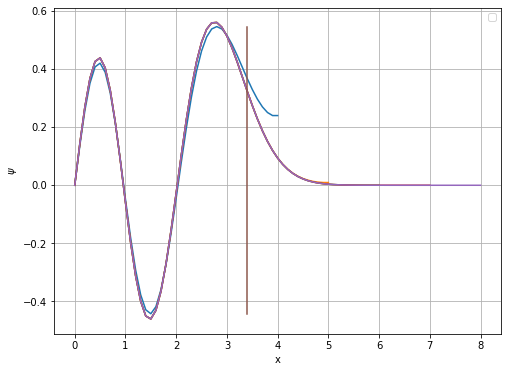

In [308]:
plt.figure(figsize = (8, 6))
plt.title('')
for i in range(5):
    plt.plot(x_1[i], y_1[i])
plt.xlabel('x')
plt.ylabel('$\psi$')
turnIndex = turnPoint(x=x, energy=energy, potential=string)
plt.plot([x_1[0][turnIndex]]*len(np.linspace(min(y_1[0]), max(y_1[0]), 4)), np.linspace(min(y_1[0]), max(y_1[0]), 4))
plt.grid()
plt.legend()

## xmax:
при слишком маленьких х мы получаем мало значений в зоне 2, следовательно на границе функция возрастает на малую величину относительно н.у.. При скэйлинге следовательно получаем, что функция не уходит в ноль(в очень маленькие значение) на краю, а имеет некоторое фиксированное значение. Что говорит нам о том, что нельзя нормировать функцию по данным х, так как за xmax в большой вероятностью можно найти частицу. При xmax большем некоторого значения, особой разницы между полученными функциями не наблюдается. Это значение можно получить, зная энергию, как расстояние от точки поворота при котором значение волновой функции упадет в е раз.
## mesh: 
если брать сетку такую, что в одном колебании будет малое число точек, то мы не получим правильный вид волновой функции. 
## deltaX: 
при сравнении минимального расстояния между соседними нулями с дельта х, мы их не сможем увидеть и соответственно программа не будет работать правильно. 

## Задание 4

In [331]:
for i in [5, 6, 7, 8, 9, 10, 11, 12, 13]:
    xmax = 10
    nmax = 100
    numNodes = i
    trialEnergy = 0
    energy, x, y = bisectionIm(xmax=xmax, nmax=nmax, numNodes=numNodes, trialEnergy=trialEnergy)
    print(i+0.5-energy)

Fist Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Desired NumNodes
2
         1	50.0000000000	        25	         2
2
         2	25.0000000000	        12	         2
2
         3	12.5000000000	         6	         2
2
         4	6.2500000000	         3	         2
2
         5	3.1250000000	         1	         2
2
         6	4.6875000000	         2	         2
--------------------------------------------------------------------------------
Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity
         7	4.6875000000	         2		-1.5838402
         8	5.4687500000	         2		-0.0966787
         9	5.8593750000	         3
Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity
        10	5.6640625000	         2		 0.4996643
        11	5.5664062500	         2		 0.2043820
     

При уменьшении дельта х мы можем прийти к решению с любой наперед заданной точностью. 
При увеличении количества узлов, разность полученной энергии и собственного значения увеличиваются.

## Задание 5. 

In [393]:
x_1, y_1 = [], []
for i in [1, 5, 10, 20]:
    xmax = 10
    nmax = 1000
    numNodes = i
    trialEnergy = 0
    energy, x, y = bisectionIm(xmax=xmax, nmax=nmax, numNodes=numNodes, trialEnergy=trialEnergy)
    x_1.append(x)
    y_1.append(y)

Fist Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Desired NumNodes
0
         1	50.0000000000	         8	         0
0
         2	25.0000000000	         5	         0
0
         3	12.5000000000	         3	         0
0
         4	6.2500000000	         2	         0
0
         5	3.1250000000	         1	         0
0
         6	1.5625000000	         0	         0
--------------------------------------------------------------------------------
Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity
         7	1.5625000000	         0		-0.2318540
         8	2.3437500000	         1
Fist Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Desired NumNodes
0
         9	1.9531250000	         1	         0
0
        10	1.7578125000	         1	         0
0
        11	1.6601562500	         0	         0
-

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  



        31	1.6614293680	         0		 0.0000002
        32	1.6614292748	         0		-0.0000000
        33	1.6614293214	         0		 0.0000001
        34	1.6614292981	         0		 0.0000000
        35	1.6614292865	         0		 0.0000000
        36	1.6614292806	         0		-0.0000000
        37	1.6614292836	         0		-0.0000000
        38	1.6614292850	         0		-0.0000000
        39	1.6614292857	         0		-0.0000000
        40	1.6614292861	         0		-0.0000000
        41	1.6614292863	         0		 0.0000000
        42	1.6614292862	         0		 0.0000000
Fist Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Desired NumNodes
2
         1	50.0000000000	         8	         2
2
         2	25.0000000000	         5	         2
2
         3	12.5000000000	         3	         2
2
         4	6.2500000000	         2	         2
--------------------------------------------------------------------------------
Second Stage
------------

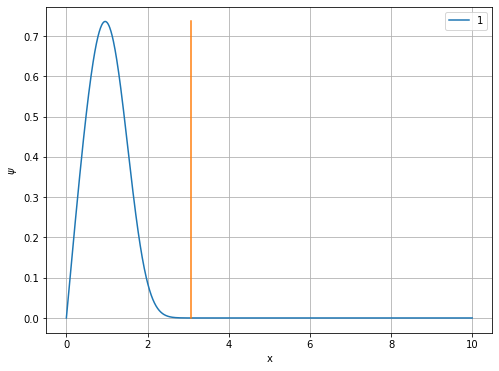

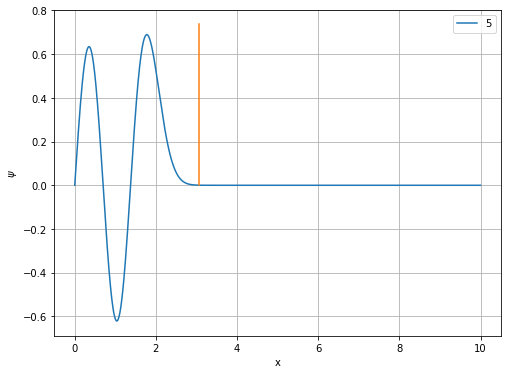

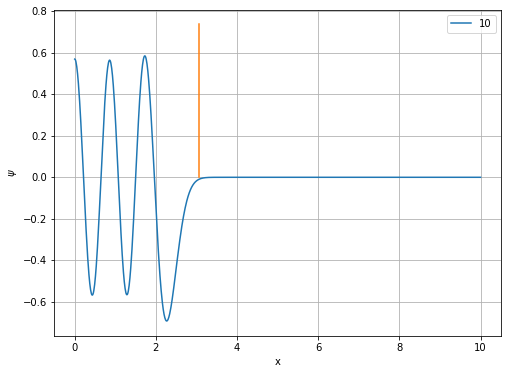

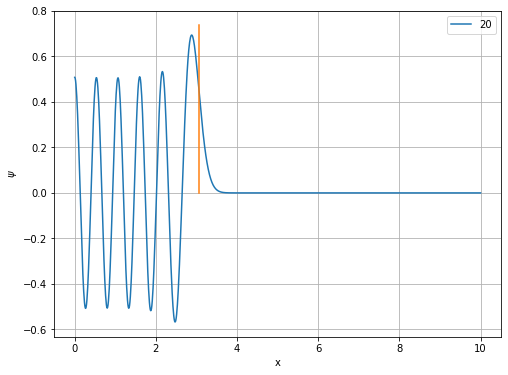

In [396]:
#plt.title('')
labels = [1, 5, 10, 20]
for i in range(4):
    plt.figure(figsize = (8, 6))
    plt.plot(x_1[i], y_1[i], label = labels[i])
    plt.xlabel('x')
    plt.ylabel('$\psi$')
    turnIndex = turnPoint(x=x, energy=energy, potential=string)
    plt.plot([x_1[0][turnIndex]]*len(np.linspace(min(y_1[0]), max(y_1[0]), 4)), np.linspace(min(y_1[0]), max(y_1[0]), 4))
    plt.grid()
    plt.legend()

## Задание 6.

In [444]:
x_1, y_1 = [], []
for i in [0, 1, 2]:
    xmax = 3
    nmax = 1000
    numNodes = i
    trialEnergy = 0
    energy, x, y = bisectionIm(xmax=xmax, nmax=nmax, numNodes=numNodes, trialEnergy=trialEnergy)
    x_1.append(x)
    y_1.append(y)

Fist Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Desired NumNodes
0
         1	50.0000000000	         8	         0
0
         2	25.0000000000	         4	         0
0
         3	12.5000000000	         2	         0
0
         4	6.2500000000	         1	         0
0
         5	3.1250000000	         0	         0
--------------------------------------------------------------------------------
Second Stage
--------------------------------------------------------------------------------
	Inter		Energy		NumNodes	Discontinuity
         6	3.1250000000	         0		-0.7282991
         7	4.6875000000	         0		 1.0958476
         8	3.9062500000	         0		 0.1853953
         9	3.5156250000	         0		-0.2718086
        10	3.7109375000	         0		-0.0432215
        11	3.8085937500	         0		 0.0710940
        12	3.7597656250	         0		 0.0139366
        13	3.7353515625	         0		-0.0146426
        14	3.7475585938	         

In [445]:
def string1(x, D = 0.9, b = 1, x0 = 1):
    return D*(np.exp(-2 * b * (x-x0)) - 2 * np.exp(-b * (x-x0)) + 1)

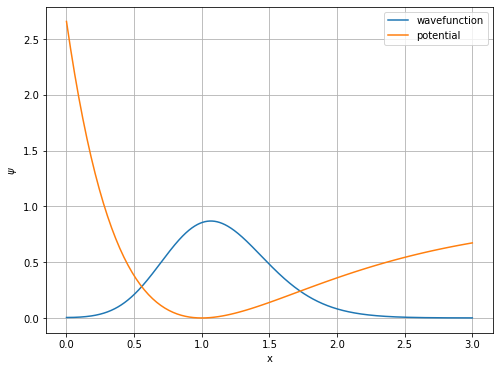

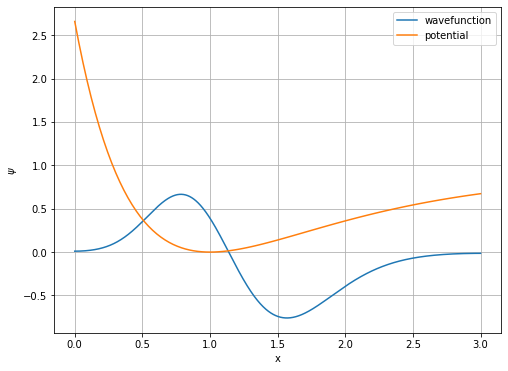

In [446]:
labels = [0, 1, 2]
for i in range(2):
    plt.figure(figsize = (8, 6))
    plt.plot(x_1[i], np.power(y_1[i], 1), label = 'wavefunction')
    plt.xlabel('x')
    plt.ylabel('$\psi$')
    k = xmax
    plt.plot(np.linspace(0, k, 100), string1(np.linspace(0, k, 100)), label = 'potential')
    #turnIndex = turnPoint(x=x, energy=energy, potential=string)
    #plt.plot([x_1[0][turnIndex]]*len(np.linspace(min(y_1[0]), max(y_1[0]), 4)), np.linspace(min(y_1[0]), max(y_1[0]), 4))
    plt.grid()
    plt.legend()
    plt.savefig('n = '+str(labels[i])+'krya')